# Using A* algorithm and TSP to determine shortest tour around waypoints in a grid

Name:Yogesh Venkatesa Perumal

Roll:106118110

## Table of Contents
* [Defining The Grid](#Define-the-grid,-waypoints-and-obstacles)
* [Computing Distance Matrix](#Computing-the-distance-matrix)
* [Travelling Salesman Solver](#Travelling-Salesman-Solver)
* [Result](#Result)

In [1]:
from queue import PriorityQueue
from itertools import combinations

import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from icecream import ic
import numpy as np
import heapq

In [2]:
# Save the original print function
original_print = print

# Define a global variable to control printing
enable_print = True

# Define a new print function that checks the global variable
def new_print(*args, **kwargs):
    if enable_print:
        original_print(*args, **kwargs)

# Replace the built-in print with the new function
print = new_print

## Define the grid, waypoints and obstacles

Each point in a grid can be space(white), a waypoint(black) or an obstacle(grey).

In [3]:
def define_grid(length=20):
    area=length*length
    indices = np.random.choice(np.arange(area), size=area//10, replace=False)
    grid = np.zeros((length, length))
    
    
    obstacles_indices,waypoints_indices= indices[:-4],indices[-4:]
    grid.flat[obstacles_indices] = 1
    grid.flat[waypoints_indices] = 2
    

    y, x = divmod(waypoints_indices, length)
    waypoints=[]
    for i,j in zip(x,y):
        waypoints.append((i,j))
    
    y, x = divmod(obstacles_indices, length)
    obstacles=[]
    for i,j in zip(x,y):
        obstacles.append((i,j))
    
    
    return grid, waypoints,obstacles

def display_the_grid_plot(*,grid,waypoints):
    plt.figure(figsize=(3, 3))
    
    plt.imshow(grid, cmap='Blues', interpolation='nearest',origin='upper')
    
    if waypoints!=None:
        for x,y in waypoints:
            plt.text(x=x,y=y,s=f"{(x,y)}",fontdict={"color":"red","size":9},
                     bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0'))
            
    plt.title("Grid with Randomised Waypoints(black) and Obstacles(grey)")
    plt.show()


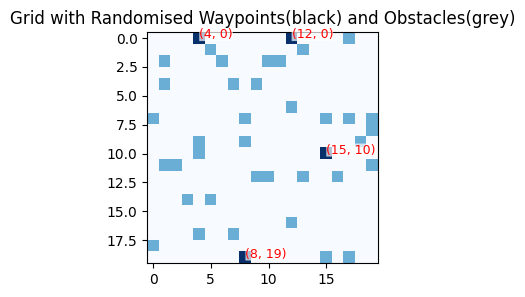

In [4]:
# Generate grid
grid,waypoints,obstacles=define_grid()
display_the_grid_plot(grid=grid,waypoints=waypoints)

In [5]:
def print_coordinates_waypoints_and_obstacles(*,waypoints,obstacles):
    print ("Waypoints are:")
    print(waypoints)
    print("Obstacles are:")
    print(obstacles)
    
print_coordinates_waypoints_and_obstacles(waypoints=waypoints,obstacles=obstacles)

Waypoints are:
[(8, 19), (12, 0), (15, 10), (4, 0)]
Obstacles are:
[(7, 4), (15, 7), (0, 18), (12, 6), (19, 11), (5, 1), (7, 17), (15, 19), (10, 2), (17, 7), (9, 12), (12, 16), (1, 2), (2, 11), (13, 1), (8, 9), (4, 17), (11, 2), (19, 7), (0, 7), (18, 9), (19, 8), (9, 4), (4, 9), (5, 14), (4, 10), (17, 19), (17, 0), (1, 4), (8, 7), (6, 2), (3, 14), (10, 12), (1, 11), (16, 12), (13, 12)]


## Computing the distance matrix

### Using A* algorithm to Compute Shortest Path bw 2 Nodes

We will be iterating through every possible pair of waypoints. For each  pair of waypoints, we will run the A* algorithm to solve 3 things

The a_star function returns a dictionary containing keys 
"shortest_path":int,
"pathway":list,
"steps_taken":int

In [6]:
class Node():
    def __init__(self,parent=None, position=None):
        self.name=f"Node{position}"
        self.parent=parent
        self.position=position # (x,y)
        self.g=0
        self.h=0
        self.f=0

    #def __eq__(self,other):
    #    return self.position==other.position

    def __lt__(self, other):
        return self.f< other.f
    
    def __str__(self):
        return self.name
    
def backtrack_and_find_pathway(*,goal_node):
    pathway=[] #stores list of (x,y) coordinates on how to reach from start to end 
    t=goal_node
    while t.parent!=None:
        pathway.insert(0,t.position)
        t=t.parent
    pathway.insert(0,t.position)
    start_node=t
    print(f"Pathway from {start_node} to {goal_node} is\n{pathway}\n")
    return pathway
    
    
def a_star(*,start, goal, grid):
    
    #ic(f"using a* to figure shortest distance bw {start} and {goal}")
    start_node = Node(parent=None, position=tuple(start))
    goal_node = Node(parent=None, position=tuple(goal))
    open_list = []
    closed_list = []
    heapq.heappush(open_list, (start_node.f, start_node))

    
    counter=0
    while open_list:
        counter+=1
        
        if counter>9999:
            raise Exception("Some problem. counter>1000")
        current_node = heapq.heappop(open_list)[1] # from the open_list, obtaining the next highest priority (sorted by fscore) 
        #ic(f"next opennode is {current_node.name}")
        if current_node.position == goal_node.position: # implicitly comparing x and y coordinates of both nodes
            return {"shortest_distance":current_node.g,
                    "pathway":backtrack_and_find_pathway(goal_node=current_node),
                    "steps":counter}

        children = []
        for new_position in [(0, -1), (0, 1), (-1, 0), (1, 0)]:
            new_node_position = (current_node.position[0] + new_position[0], current_node.position[1] + new_position[1])

            #node meeting one of these criteria will fail to be a potential future node to search
            if new_node_position[0] > (len(grid) - 1):
                #ic(f"node {node_position} border at bottom")
                continue
            elif new_node_position[0] < 0:
                #ic(f"node {node_position} border at top")
                continue
            elif new_node_position[1] > (len(grid[0]) - 1):
                #ic(f"node {node_position} border at right")
                continue
            elif new_node_position[1] < 0:
                #ic(f"node {node_position} border at left")
                continue
            
            if grid[new_node_position[1]][new_node_position[0]] == 1: # encountered obstacle
                #ic(f"encountered obstacle at {(new_node_position[0],new_node_position[1])}. fail.")
                continue
                
            # if here, the node has passed all the tests
            new_node = Node(parent=current_node, position=new_node_position)
            children.append(new_node)
        
        
            
        #print("camehere")
        #ic("iterated in all 4 directions")
        for child in children: # intent- final checks before adding child to open_list
            if child in closed_list:
                continue

            child.g = current_node.g + 1 # true distance travelled upto now
            child.h = abs(child.position[0] - goal_node.position[0]) + abs(child.position[1] - goal_node.position[1])
            child.f = child.g + child.h

            if any(child.position == open_node[1].position and child.g > open_node[1].g for open_node in open_list):
                continue
                
            # came here, this child node is perfectly eligible for future exploration
            heapq.heappush(open_list, (child.f, child)) 
            
        
        closed_list.append(current_node)
        #ic(f"closed_list is {closed_list}")
        
        
    return []



### Compute Distance matrix

In [7]:

def compute_distance_matrix(*,waypoints,grid):
    ap={}
    mapper_index_to_position={}
    list_counters=[]
    n_rows,n_cols = len(waypoints),len(waypoints)
    distance_matrix = [[0 for j in range(n_cols)] for i in range(n_rows)]
    
    for i in range(len(waypoints)):
        for j in range(len(waypoints)):
            if i == j:
                continue
            
            start=waypoints[i] #start = (x,y)
            goal=waypoints[j] # end = (x,y)
            
            
            shortest_distance,pathway,steps= a_star(grid=grid,start=start,goal=goal).values()
            
            list_counters.append(steps)
            
            #filling up the distance matrix
            distance_matrix[i][j]=len(pathway)-1
            mapper_index_to_position[(i,j)]=(start,goal)
            ap[(start),(goal)]={"pathway":pathway,"distance":len(pathway)-1,"steps_to_converge":steps}
                                
                
    return distance_matrix,mapper_index_to_position,ap


In [8]:
distance_matrix,mapper_index_to_position,ap=compute_distance_matrix(waypoints=waypoints,grid=grid)
# distance_matrix is storing the shortest paths
# mapper_index_to_position is used to get back (x,y) coordinates using index i (needed after tsp_solve)
# ap is a dict that returns [pathway,distance] on supplying (start,goal)

Pathway from Node(8, 19) to Node(12, 0) is
[(8, 19), (8, 18), (9, 18), (9, 17), (9, 16), (9, 15), (9, 14), (10, 14), (10, 13), (11, 13), (11, 12), (11, 11), (11, 10), (11, 9), (11, 8), (11, 7), (11, 6), (11, 5), (11, 4), (11, 3), (12, 3), (12, 2), (12, 1), (12, 0)]

Pathway from Node(8, 19) to Node(15, 10) is
[(8, 19), (8, 18), (8, 17), (9, 17), (10, 17), (11, 17), (12, 17), (13, 17), (13, 16), (13, 15), (14, 15), (14, 14), (14, 13), (15, 13), (15, 12), (15, 11), (15, 10)]

Pathway from Node(8, 19) to Node(4, 0) is
[(8, 19), (8, 18), (8, 17), (8, 16), (8, 15), (8, 14), (7, 14), (7, 13), (7, 12), (7, 11), (7, 10), (7, 9), (6, 9), (6, 8), (6, 7), (6, 6), (6, 5), (5, 5), (5, 4), (5, 3), (5, 2), (4, 2), (4, 1), (4, 0)]

Pathway from Node(12, 0) to Node(8, 19) is
[(12, 0), (12, 1), (12, 2), (12, 3), (12, 4), (11, 4), (11, 5), (10, 5), (10, 6), (10, 7), (10, 8), (10, 9), (9, 9), (9, 10), (8, 10), (8, 11), (8, 12), (8, 13), (8, 14), (8, 15), (8, 16), (8, 17), (8, 18), (8, 19)]

Pathway from N

In [9]:
pd.DataFrame(distance_matrix)

,0,1,2,3
0,0,23,16,23
1,23,0,13,8
2,16,13,0,21
3,23,8,21,0


In [10]:
#an example ap
literal_first_key=list(ap.keys())[0]
print(ap[literal_first_key])

{'pathway': [(8, 19), (8, 18), (9, 18), (9, 17), (9, 16), (9, 15), (9, 14), (10, 14), (10, 13), (11, 13), (11, 12), (11, 11), (11, 10), (11, 9), (11, 8), (11, 7), (11, 6), (11, 5), (11, 4), (11, 3), (12, 3), (12, 2), (12, 1), (12, 0)], 'distance': 23, 'steps_to_converge': 286}


### Plots for all computed shortest points

In [11]:
for (start,goal),values in ap.items():
    pathway=values["pathway"]
    distance=values["distance"]
    steps=values["steps_to_converge"]
    print(steps)
    break

286


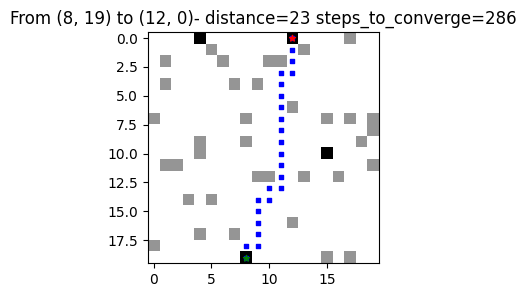

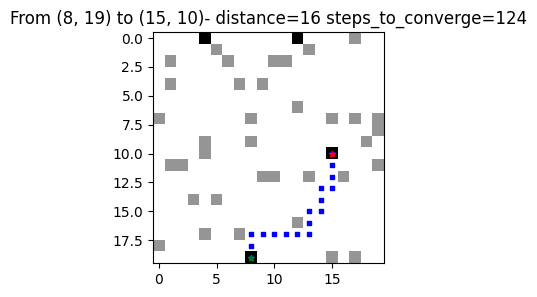

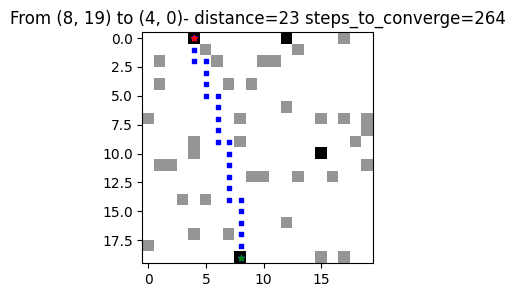

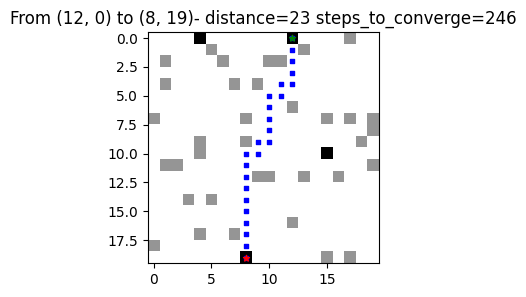

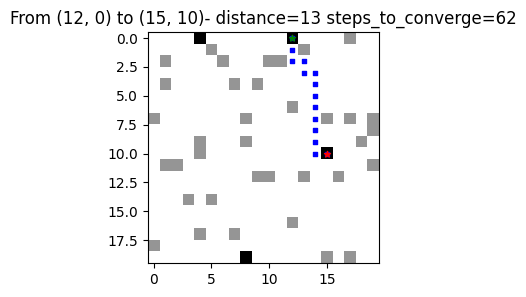

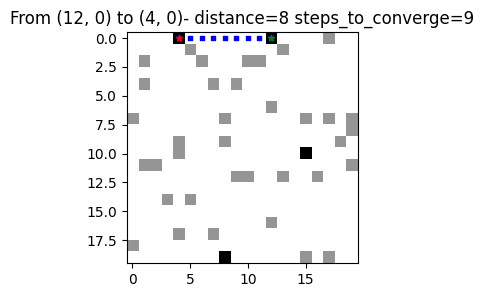

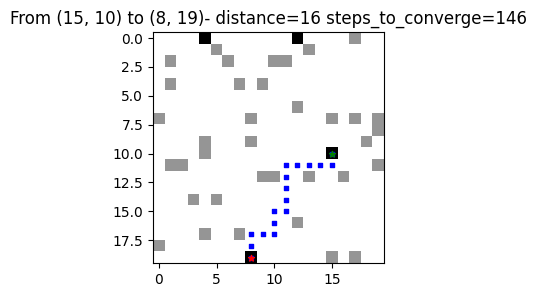

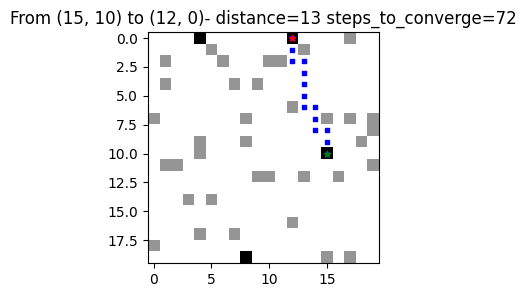

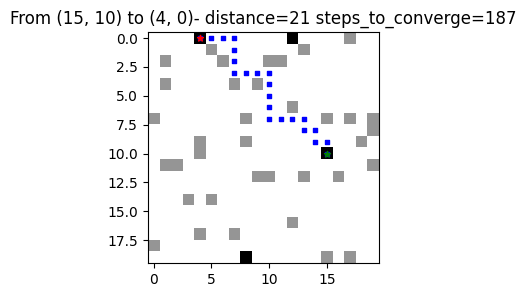

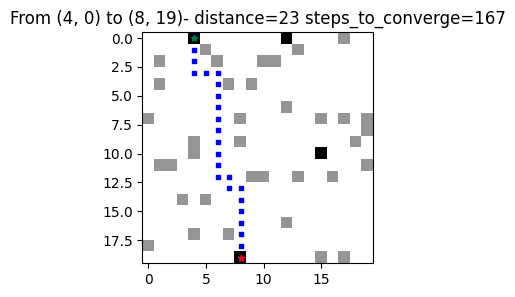

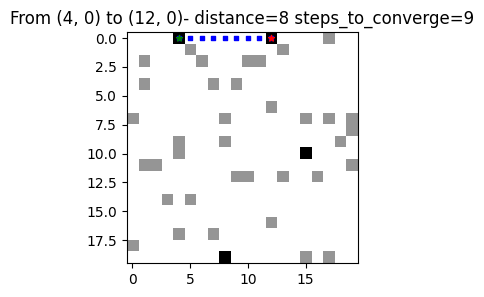

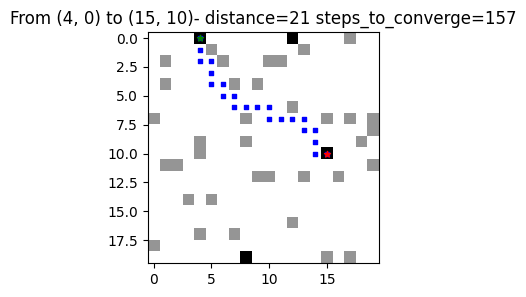

In [12]:
def plot_all_a_star_plots():
    for (start,goal),values in ap.items():
        pathway=values["pathway"]
        distance=values["distance"]
        steps=values["steps_to_converge"]

        fig, ax = plt.subplots(figsize=(3, 3))
        ax.imshow(grid, cmap='Greys', origin='upper')

        # Mark the path
        for step in pathway:
            ax.scatter(step[0], step[1], marker='s', color='blue', s=10)

        # Mark the start and goal positions
        ax.scatter(start[0], start[1], marker='*', color='green', s=20)
        ax.scatter(goal[0], goal[1], marker='*', color='red', s=20)
        ax.set_title(f"From {start} to {goal}- distance={distance} steps_to_converge={steps}")
        plt.show()
plot_all_a_star_plots()

## Travelling Salesman Solver

In [13]:
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp

def solve_tsp(distance_matrix):
    manager = pywrapcp.RoutingIndexManager(len(distance_matrix), 1, 0)
    routing = pywrapcp.RoutingModel(manager)

    def distance_callback(from_index, to_index):
        # Convert routing variable indices to distance matrix indices.
        from_node = manager.IndexToNode(from_index)
        to_node = manager.IndexToNode(to_index)
        # Retrieve the distance, handling infinity properly.
        distance = distance_matrix[from_node][to_node]
        if np.isinf(distance):
            return routing_model.registered_penalty()  # Large penalty for infeasible paths
        return int(distance)  # Convert float to int if necessar
        
    transit_callback_index = routing.RegisterTransitCallback(distance_callback)
    routing.SetArcCostEvaluatorOfAllVehicles(transit_callback_index)
    search_parameters = pywrapcp.DefaultRoutingSearchParameters()
    search_parameters.first_solution_strategy = routing_enums_pb2.FirstSolutionStrategy.PATH_CHEAPEST_ARC

    solution = routing.Solve()
    if solution:
        index = routing.Start(0)
        plan_output = [] #'Route:\n'
        route_distance = 0
        while not routing.IsEnd(index):
            plan_output.append(manager.IndexToNode(index)) #+= f' {manager.IndexToNode(index)} ->'
            previous_index = index
            index = solution.Value(routing.NextVar(index))
            route_distance += routing.GetArcCostForVehicle(previous_index, index, 0)
        plan_output.append(manager.IndexToNode(index)) #+= f'{manager.IndexToNode(index)}\n'
    return plan_output,route_distance

plan_output,route_distance=solve_tsp(distance_matrix=distance_matrix)
print(plan_output)
print(route_distance)

[0, 2, 1, 3, 0]
60


In [14]:

def interpret_tsp_solver_result(*,distance_matrix,plan_output,route_distance):
    print("For the previously computed distance matrix that is")
    display(pd.DataFrame(distance_matrix))
    plan_output,route_distance=solve_tsp(distance_matrix=distance_matrix)

    print(f"Result of TSP Solver was{plan_output}\n")

    plan_output_mapped=[] 
    for i in range(len(plan_output)-1):
        index_now=plan_output[i]
        index_next=plan_output[i+1]

        plan_output_mapped.append(mapper_index_to_position[index_now,index_next])
    print(f"Therefore proposed route is {plan_output_mapped}")

    print(f'Total Route distance: {route_distance}')

interpret_tsp_solver_result(distance_matrix=distance_matrix,plan_output=plan_output,route_distance=route_distance)

For the previously computed distance matrix that is


,0,1,2,3
0,0,23,16,23
1,23,0,13,8
2,16,13,0,21
3,23,8,21,0


Result of TSP Solver was[0, 2, 1, 3, 0]

Therefore proposed route is [((8, 19), (15, 10)), ((15, 10), (12, 0)), ((12, 0), (4, 0)), ((4, 0), (8, 19))]
Total Route distance: 60


## Result 

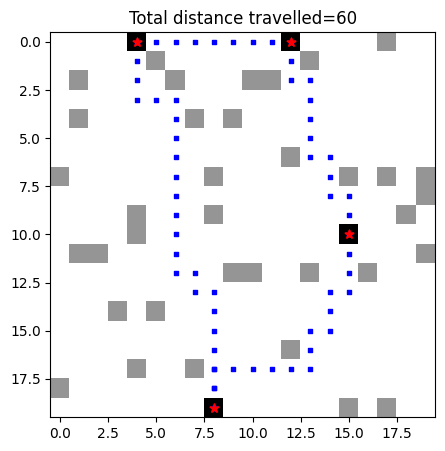

In [15]:
def  display_final_diagram():
    fig, ax = plt.subplots(figsize=(5, 5))
    ax.imshow(grid, cmap='Greys', origin='upper')

    for i in range(len(plan_output)-1):
        index_now=plan_output[i]
        index_next=plan_output[i+1]

        start,goal=mapper_index_to_position[(index_now,index_next)]
        pathway=ap[(start,goal)]['pathway']
        distance=ap[(start,goal)]['distance']
        steps=ap[(start,goal)]['steps_to_converge']
        
    
        # Mark the path
        for (step_x,step_y) in pathway:
            ax.scatter(step_x, step_y, marker='s', color='blue', s=10)

        #marking the start and goal positions
        ax.scatter(start[0], start[1], marker='*', color='red', s=40)
        ax.scatter(goal[0], goal[1], marker='*', color='red', s=40)
    ax.set_title(f"Total distance travelled={route_distance}")
    plt.show()
    
display_final_diagram()

### Other Statistics

In [16]:
def retrieve_df(*,ap):
    df=pd.DataFrame(ap).T

    df = df.astype({'distance': int, 'steps_to_converge': int})
    return df
def display_df(*,df):
    display(df)
    df.describe()

def retrieve_summary(*,df):
    return df.describe()


In [55]:
df=retrieve_df(ap=ap)
display_df(df=df[["distance","steps_to_converge"]])

distance  steps_to_converge
(8, 19)  (12, 0)         23                286
         (15, 10)        16                124
         (4, 0)          23                264
(12, 0)  (8, 19)         23                246
         (15, 10)        13                 62
         (4, 0)           8                  9
(15, 10) (8, 19)         16                146
         (12, 0)         13                 72
         (4, 0)          21                187
(4, 0)   (8, 19)         23                167
         (12, 0)          8                  9
         (15, 10)        21                157

In [17]:
df_summaries=[]
def run_one_simulation():
    global enable_print
    #del grid,waypoints,obstacles
    grid,waypoints,obstacles=define_grid()
    
    enable_print=False
    distance_matrix,mapper_index_to_position,ap=compute_distance_matrix(waypoints=waypoints,grid=grid)
        
    display_the_grid_plot(grid=grid,waypoints=waypoints)
    
    
    #plot_all_a_star_plots()
    
    plan_output,route_distance=solve_tsp(distance_matrix=distance_matrix)
    interpret_tsp_solver_result(distance_matrix=distance_matrix,plan_output=plan_output,route_distance=route_distance)
    enable_print=True
    #display_final_diagram()
    df=retrieve_df(ap=ap)[["",""]]
    display_df(df=df)
    return retrieve_summary(df=df)
    
    

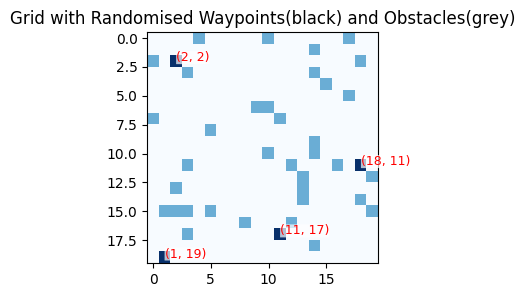

,0,1,2,3
0,0,13,25,25
1,13,0,12,24
2,25,12,0,20
3,25,24,20,0


pathway  \
(18, 11) (11, 17)  [(18, 11), (18, 12), (18, 13), (17, 13), (16, ...   
         (1, 19)   [(18, 11), (18, 12), (18, 13), (17, 13), (17, ...   
         (2, 2)    [(18, 11), (18, 10), (18, 9), (18, 8), (18, 7)...   
(11, 17) (18, 11)  [(11, 17), (12, 17), (13, 17), (14, 17), (15, ...   
         (1, 19)   [(11, 17), (10, 17), (9, 17), (9, 18), (9, 19)...   
         (2, 2)    [(11, 17), (11, 16), (11, 15), (11, 14), (10, ...   
(1, 19)  (18, 11)  [(1, 19), (2, 19), (3, 19), (3, 18), (4, 18), ...   
         (11, 17)  [(1, 19), (2, 19), (3, 19), (4, 19), (5, 19), ...   
         (2, 2)    [(1, 19), (1, 18), (1, 17), (1, 16), (0, 16), ...   
(2, 2)   (18, 11)  [(2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (2, 7...   
         (11, 17)  [(2, 2), (3, 2), (4, 2), (4, 3), (5, 3), (6, 3...   
         (1, 19)   [(2, 2), (2, 3), (2, 4), (2, 5), (2, 6), (1, 6...   

                   distance  steps_to_converge  
(18, 11) (11, 17)        13                 69  
         (1, 19)         25                352  
         (2, 2)          25                175  
(11, 17) (18, 11)        13                 48  
         (1, 19)         12                 66  
         (2, 2)          24                311  
(1, 19)  (18, 11)        25                395  
         (11, 17)        12                 56  
         (2, 2)          20                211  
(2, 2)   (18, 11)        25                261  
         (11, 17)        24                317  
         (1, 19)         20                212

,distance,steps_to_converge
count,12.000000,12.000000
mean,19.833333,206.083333
std,5.702206,124.412407
min,12.000000,48.000000
25%,13.000000,68.250000
50%,22.000000,211.500000
75%,25.000000,312.500000
max,25.000000,395.000000


In [18]:
run_one_simulation()

EXPERIMENT 0


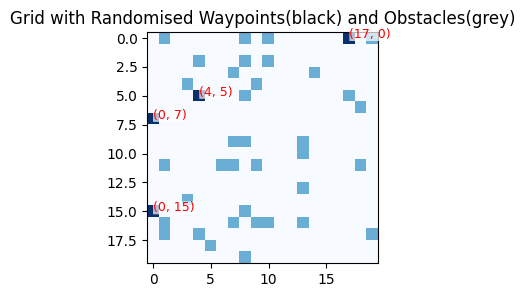

,0,1,2,3
0,0,6,14,18
1,6,0,8,24
2,14,8,0,32
3,18,24,32,0


pathway  distance  \
(4, 5)  (0, 7)   [(4, 5), (3, 5), (3, 6), (2, 6), (2, 7), (1, 7...         6   
        (0, 15)  [(4, 5), (3, 5), (3, 6), (3, 7), (2, 7), (2, 8...        14   
        (17, 0)  [(4, 5), (5, 5), (5, 4), (5, 3), (6, 3), (6, 2...        18   
(0, 7)  (4, 5)   [(0, 7), (0, 6), (0, 5), (1, 5), (2, 5), (3, 5...         6   
        (0, 15)  [(0, 7), (0, 8), (0, 9), (0, 10), (0, 11), (0,...         8   
        (17, 0)  [(0, 7), (1, 7), (1, 6), (1, 5), (2, 5), (3, 5...        24   
(0, 15) (4, 5)   [(0, 15), (1, 15), (1, 14), (2, 14), (2, 13), ...        14   
        (0, 7)   [(0, 15), (0, 14), (0, 13), (0, 12), (0, 11), ...         8   
        (17, 0)  [(0, 15), (0, 14), (1, 14), (2, 14), (2, 13), ...        32   
(17, 0) (4, 5)   [(17, 0), (16, 0), (15, 0), (14, 0), (13, 0), ...        18   
        (0, 7)   [(17, 0), (16, 0), (15, 0), (15, 1), (14, 1), ...        24   
        (0, 15)  [(17, 0), (16, 0), (15, 0), (15, 1), (14, 1), ...        32   

                 steps_to_converge  
(4, 5)  (0, 7)                  22  
        (0, 15)                 91  
        (17, 0)                 74  
(0, 7)  (4, 5)                  15  
        (0, 15)                  9  
        (17, 0)                157  
(0, 15) (4, 5)                  73  
        (0, 7)                   9  
        (17, 0)                734  
(17, 0) (4, 5)                 164  
        (0, 7)                 155  
        (0, 15)                298

EXPERIMENT 1


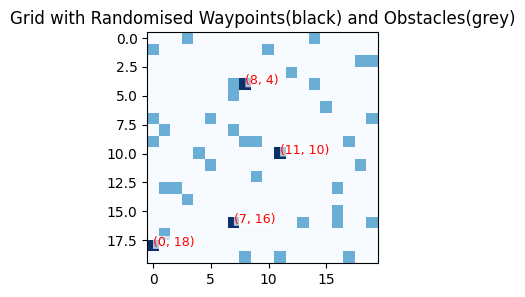

,0,1,2,3
0,0,19,9,22
1,19,0,10,9
2,9,10,0,15
3,22,9,15,0


pathway  \
(0, 18)  (11, 10)  [(0, 18), (1, 18), (2, 18), (3, 18), (3, 17), ...   
         (7, 16)   [(0, 18), (1, 18), (2, 18), (2, 17), (3, 17), ...   
         (8, 4)    [(0, 18), (0, 17), (0, 16), (1, 16), (2, 16), ...   
(11, 10) (0, 18)   [(11, 10), (11, 11), (10, 11), (10, 12), (10, ...   
         (7, 16)   [(11, 10), (11, 11), (10, 11), (10, 12), (10, ...   
         (8, 4)    [(11, 10), (11, 9), (10, 9), (10, 8), (9, 8), ...   
(7, 16)  (0, 18)   [(7, 16), (6, 16), (6, 17), (5, 17), (5, 18), ...   
         (11, 10)  [(7, 16), (7, 15), (7, 14), (7, 13), (8, 13), ...   
         (8, 4)    [(7, 16), (7, 15), (7, 14), (7, 13), (7, 12), ...   
(8, 4)   (0, 18)   [(8, 4), (8, 5), (8, 6), (7, 6), (6, 6), (6, 7...   
         (11, 10)  [(8, 4), (8, 5), (9, 5), (9, 6), (9, 7), (10, ...   
         (7, 16)   [(8, 4), (8, 5), (8, 6), (8, 7), (7, 7), (6, 7...   

                   distance  steps_to_converge  
(0, 18)  (11, 10)        19                147  
         (7, 16)          9                 28  
         (8, 4)          22                284  
(11, 10) (0, 18)         19                 83  
         (7, 16)         10                 35  
         (8, 4)           9                 27  
(7, 16)  (0, 18)          9                 35  
         (11, 10)        10                 47  
         (8, 4)          15                169  
(8, 4)   (0, 18)         22                152  
         (11, 10)         9                 36  
         (7, 16)         15                 61

EXPERIMENT 2


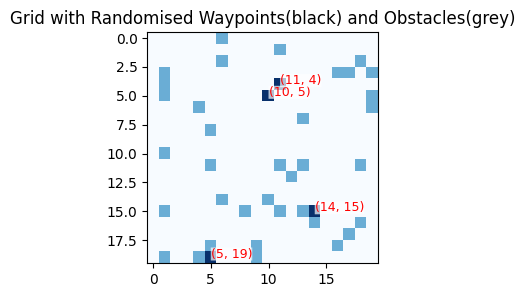

,0,1,2,3
0,0,15,19,21
1,15,0,14,14
2,19,14,0,2
3,21,14,2,0


pathway  \
(5, 19)  (14, 15)  [(5, 19), (6, 19), (7, 19), (7, 18), (7, 17), ...   
         (10, 5)   [(5, 19), (6, 19), (6, 18), (6, 17), (7, 17), ...   
         (11, 4)   [(5, 19), (6, 19), (6, 18), (6, 17), (6, 16), ...   
(14, 15) (5, 19)   [(14, 15), (14, 14), (13, 14), (12, 14), (12, ...   
         (10, 5)   [(14, 15), (14, 14), (14, 13), (14, 12), (14, ...   
         (11, 4)   [(14, 15), (14, 14), (14, 13), (14, 12), (14, ...   
(10, 5)  (5, 19)   [(10, 5), (10, 6), (9, 6), (9, 7), (9, 8), (9,...   
         (14, 15)  [(10, 5), (10, 6), (10, 7), (10, 8), (10, 9), ...   
         (11, 4)                         [(10, 5), (10, 4), (11, 4)]   
(11, 4)  (5, 19)   [(11, 4), (11, 5), (11, 6), (10, 6), (10, 7), ...   
         (14, 15)  [(11, 4), (12, 4), (12, 5), (13, 5), (13, 6), ...   
         (10, 5)                         [(11, 4), (11, 5), (10, 5)]   

                   distance  steps_to_converge  
(5, 19)  (14, 15)        15                494  
         (10, 5)         19                155  
         (11, 4)         21                155  
(14, 15) (5, 19)         15                 78  
         (10, 5)         14                115  
         (11, 4)         14                 57  
(10, 5)  (5, 19)         19                520  
         (14, 15)        14                135  
         (11, 4)          2                  4  
(11, 4)  (5, 19)         21                304  
         (14, 15)        14                 67  
         (10, 5)          2                  4

EXPERIMENT 3


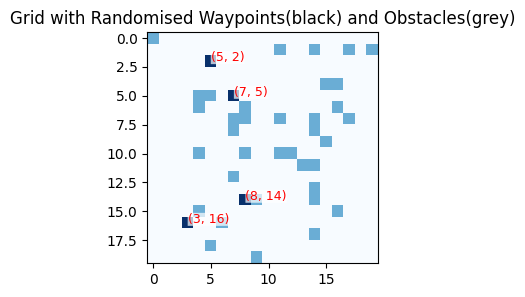

,0,1,2,3
0,0,5,15,12
1,5,0,16,15
2,15,16,0,7
3,12,15,7,0


pathway  distance  \
(7, 5)  (5, 2)    [(7, 5), (7, 4), (7, 3), (7, 2), (6, 2), (5, 2)]         5   
        (3, 16)  [(7, 5), (6, 5), (6, 6), (6, 7), (6, 8), (5, 8...        15   
        (8, 14)  [(7, 5), (8, 5), (9, 5), (9, 6), (9, 7), (9, 8...        12   
(5, 2)  (7, 5)    [(5, 2), (5, 3), (6, 3), (6, 4), (7, 4), (7, 5)]         5   
        (3, 16)  [(5, 2), (4, 2), (3, 2), (3, 3), (3, 4), (3, 5...        16   
        (8, 14)  [(5, 2), (6, 2), (6, 3), (6, 4), (6, 5), (6, 6...        15   
(3, 16) (7, 5)   [(3, 16), (3, 15), (3, 14), (3, 13), (3, 12), ...        15   
        (5, 2)   [(3, 16), (3, 15), (3, 14), (3, 13), (3, 12), ...        16   
        (8, 14)  [(3, 16), (3, 15), (3, 14), (4, 14), (5, 14), ...         7   
(8, 14) (7, 5)   [(8, 14), (8, 13), (8, 12), (8, 11), (7, 11), ...        12   
        (5, 2)   [(8, 14), (8, 13), (8, 12), (8, 11), (7, 11), ...        15   
        (3, 16)  [(8, 14), (7, 14), (7, 15), (6, 15), (5, 15), ...         7   

                 steps_to_converge  
(7, 5)  (5, 2)                  13  
        (3, 16)                 69  
        (8, 14)                 51  
(5, 2)  (7, 5)                  15  
        (3, 16)                 64  
        (8, 14)                 89  
(3, 16) (7, 5)                  60  
        (5, 2)                 137  
        (8, 14)                 18  
(8, 14) (7, 5)                  50  
        (5, 2)                  62  
        (3, 16)                 23

EXPERIMENT 4


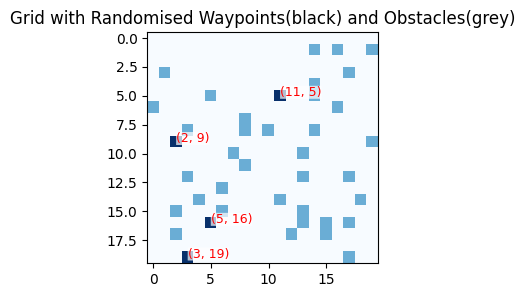

,0,1,2,3
0,0,11,22,5
1,11,0,13,10
2,22,13,0,17
3,5,10,17,0


pathway  distance  \
(3, 19) (2, 9)   [(3, 19), (3, 18), (3, 17), (3, 16), (3, 15), ...        11   
        (11, 5)  [(3, 19), (3, 18), (4, 18), (4, 17), (4, 16), ...        22   
        (5, 16)  [(3, 19), (3, 18), (3, 17), (4, 17), (5, 17), ...         5   
(2, 9)  (3, 19)  [(2, 9), (2, 10), (2, 11), (2, 12), (2, 13), (...        11   
        (11, 5)  [(2, 9), (2, 8), (2, 7), (3, 7), (3, 6), (4, 6...        13   
        (5, 16)  [(2, 9), (2, 10), (3, 10), (3, 11), (4, 11), (...        10   
(11, 5) (3, 19)  [(11, 5), (10, 5), (9, 5), (9, 6), (8, 6), (7,...        22   
        (2, 9)   [(11, 5), (10, 5), (9, 5), (8, 5), (7, 5), (7,...        13   
        (5, 16)  [(11, 5), (10, 5), (9, 5), (8, 5), (8, 6), (7,...        17   
(5, 16) (3, 19)  [(5, 16), (5, 17), (4, 17), (4, 18), (4, 19), ...         5   
        (2, 9)   [(5, 16), (4, 16), (4, 15), (3, 15), (3, 14), ...        10   
        (11, 5)  [(5, 16), (5, 15), (5, 14), (6, 14), (7, 14), ...        17   

                 steps_to_converge  
(3, 19) (2, 9)                  21  
        (11, 5)                153  
        (5, 16)                 15  
(2, 9)  (3, 19)                 24  
        (11, 5)                 67  
        (5, 16)                 30  
(11, 5) (3, 19)                162  
        (2, 9)                 107  
        (5, 16)                119  
(5, 16) (3, 19)                 15  
        (2, 9)                  34  
        (11, 5)                143

EXPERIMENT 5


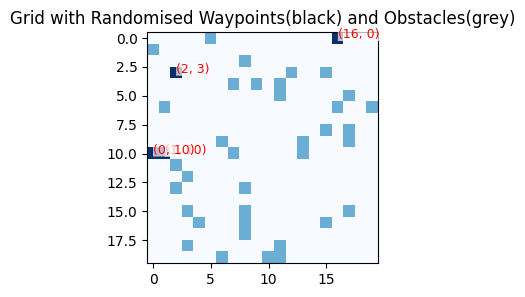

,0,1,2,3
0,0,1,8,25
1,1,0,9,26
2,8,9,0,17
3,25,26,17,0


pathway  distance  \
(1, 10) (0, 10)                                 [(1, 10), (0, 10)]         1   
        (2, 3)   [(1, 10), (1, 9), (1, 8), (1, 7), (2, 7), (2, ...         8   
        (16, 0)  [(1, 10), (1, 9), (1, 8), (1, 7), (2, 7), (3, ...        25   
(0, 10) (1, 10)                                 [(0, 10), (1, 10)]         1   
        (2, 3)   [(0, 10), (0, 9), (0, 8), (1, 8), (1, 7), (2, ...         9   
        (16, 0)  [(0, 10), (1, 10), (1, 9), (1, 8), (2, 8), (2,...        26   
(2, 3)  (1, 10)  [(2, 3), (2, 4), (2, 5), (2, 6), (2, 7), (2, 8...         8   
        (0, 10)  [(2, 3), (1, 3), (0, 3), (0, 4), (0, 5), (0, 6...         9   
        (16, 0)  [(2, 3), (2, 2), (3, 2), (3, 1), (4, 1), (5, 1...        17   
(16, 0) (1, 10)  [(16, 0), (16, 1), (15, 1), (14, 1), (14, 2), ...        25   
        (0, 10)  [(16, 0), (16, 1), (15, 1), (14, 1), (14, 2), ...        26   
        (2, 3)   [(16, 0), (15, 0), (14, 0), (13, 0), (13, 1), ...        17   

                 steps_to_converge  
(1, 10) (0, 10)                  2  
        (2, 3)                  22  
        (16, 0)                225  
(0, 10) (1, 10)                  2  
        (2, 3)                  30  
        (16, 0)                363  
(2, 3)  (1, 10)                 20  
        (0, 10)                 31  
        (16, 0)                 61  
(16, 0) (1, 10)                338  
        (0, 10)                346  
        (2, 3)                  76

EXPERIMENT 6


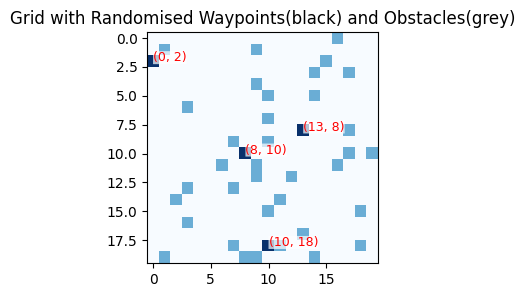

,0,1,2,3
0,0,13,7,19
1,13,0,10,26
2,7,10,0,16
3,19,26,16,0


pathway  \
(13, 8)  (10, 18)  [(13, 8), (13, 9), (13, 10), (13, 11), (13, 12...   
         (8, 10)   [(13, 8), (13, 9), (12, 9), (11, 9), (11, 10),...   
         (0, 2)    [(13, 8), (13, 7), (12, 7), (12, 6), (12, 5), ...   
(10, 18) (13, 8)   [(10, 18), (10, 17), (11, 17), (11, 16), (12, ...   
         (8, 10)   [(10, 18), (10, 17), (10, 16), (9, 16), (8, 16...   
         (0, 2)    [(10, 18), (9, 18), (9, 17), (9, 16), (9, 15),...   
(8, 10)  (13, 8)   [(8, 10), (8, 9), (8, 8), (9, 8), (10, 8), (11...   
         (10, 18)  [(8, 10), (8, 11), (8, 12), (8, 13), (8, 14), ...   
         (0, 2)    [(8, 10), (8, 9), (8, 8), (8, 7), (7, 7), (6, ...   
(0, 2)   (13, 8)   [(0, 2), (1, 2), (1, 3), (1, 4), (2, 4), (2, 5...   
         (10, 18)  [(0, 2), (0, 3), (1, 3), (2, 3), (2, 4), (3, 4...   
         (8, 10)   [(0, 2), (0, 3), (1, 3), (2, 3), (3, 3), (4, 3...   

                   distance  steps_to_converge  
(13, 8)  (10, 18)        13                158  
         (8, 10)          7                 25  
         (0, 2)          19                124  
(10, 18) (13, 8)         13                 66  
         (8, 10)         10                 54  
         (0, 2)          26                352  
(8, 10)  (13, 8)          7                 19  
         (10, 18)        10                 31  
         (0, 2)          16                 97  
(0, 2)   (13, 8)         19                146  
         (10, 18)        26                425  
         (8, 10)         16                157

EXPERIMENT 7


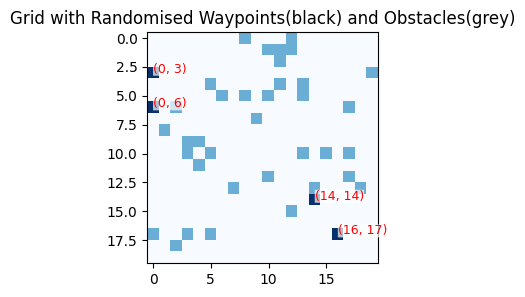

,0,1,2,3
0,0,25,5,22
1,25,0,30,3
2,5,30,0,27
3,22,3,27,0


pathway  \
(14, 14) (0, 3)    [(14, 14), (13, 14), (13, 13), (13, 12), (13, ...   
         (16, 17)  [(14, 14), (15, 14), (15, 15), (15, 16), (16, ...   
         (0, 6)    [(14, 14), (13, 14), (13, 13), (13, 12), (13, ...   
(0, 3)   (14, 14)  [(0, 3), (0, 4), (0, 5), (1, 5), (2, 5), (3, 5...   
         (16, 17)  [(0, 3), (0, 4), (0, 5), (1, 5), (2, 5), (3, 5...   
         (0, 6)                     [(0, 3), (0, 4), (0, 5), (0, 6)]   
(16, 17) (14, 14)  [(16, 17), (15, 17), (15, 16), (15, 15), (14, ...   
         (0, 3)    [(16, 17), (15, 17), (15, 16), (14, 16), (14, ...   
         (0, 6)    [(16, 17), (15, 17), (15, 16), (14, 16), (14, ...   
(0, 6)   (14, 14)  [(0, 6), (1, 6), (1, 7), (2, 7), (3, 7), (4, 7...   
         (0, 3)                     [(0, 6), (0, 5), (0, 4), (0, 3)]   
         (16, 17)  [(0, 6), (1, 6), (1, 7), (2, 7), (3, 7), (3, 8...   

                   distance  steps_to_converge  
(14, 14) (0, 3)          25                187  
         (16, 17)         5                 12  
         (0, 6)          22                129  
(0, 3)   (14, 14)        25                280  
         (16, 17)        30                361  
         (0, 6)           3                  4  
(16, 17) (14, 14)         5                 19  
         (0, 3)          30                356  
         (0, 6)          27                336  
(0, 6)   (14, 14)        22                152  
         (0, 3)           3                  4  
         (16, 17)        27                326

EXPERIMENT 8


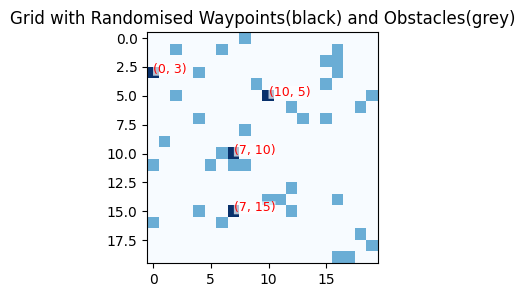

,0,1,2,3
0,0,8,13,12
1,8,0,9,14
2,13,9,0,19
3,12,14,19,0


pathway  distance  \
(10, 5) (7, 10)  [(10, 5), (10, 6), (9, 6), (8, 6), (7, 6), (7,...         8   
        (7, 15)  [(10, 5), (10, 6), (10, 7), (9, 7), (9, 8), (9...        13   
        (0, 3)   [(10, 5), (9, 5), (8, 5), (7, 5), (7, 4), (6, ...        12   
(7, 10) (10, 5)  [(7, 10), (7, 9), (7, 8), (7, 7), (7, 6), (8, ...         8   
        (7, 15)  [(7, 10), (8, 10), (9, 10), (9, 11), (9, 12), ...         9   
        (0, 3)   [(7, 10), (7, 9), (7, 8), (6, 8), (5, 8), (5, ...        14   
(7, 15) (10, 5)  [(7, 15), (7, 14), (7, 13), (8, 13), (8, 12), ...        13   
        (7, 10)  [(7, 15), (8, 15), (9, 15), (9, 14), (9, 13), ...         9   
        (0, 3)   [(7, 15), (6, 15), (6, 14), (6, 13), (5, 13), ...        19   
(0, 3)  (10, 5)  [(0, 3), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4...        12   
        (7, 10)  [(0, 3), (1, 3), (1, 4), (2, 4), (3, 4), (4, 4...        14   
        (7, 15)  [(0, 3), (0, 4), (0, 5), (1, 5), (1, 6), (1, 7...        19   

                 steps_to_converge  
(10, 5) (7, 10)                 29  
        (7, 15)                 99  
        (0, 3)                  59  
(7, 10) (10, 5)                 26  
        (7, 15)                 44  
        (0, 3)                  46  
(7, 15) (10, 5)                 66  
        (7, 10)                230  
        (0, 3)                 199  
(0, 3)  (10, 5)                 56  
        (7, 10)                 70  
        (7, 15)                156

EXPERIMENT 9


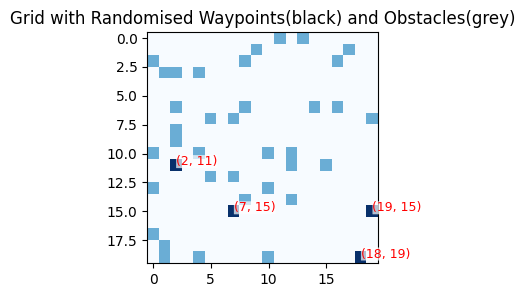

,0,1,2,3
0,0,9,21,24
1,9,0,12,15
2,21,12,0,5
3,24,15,5,0


pathway  \
(2, 11)  (7, 15)   [(2, 11), (2, 12), (3, 12), (4, 12), (4, 13), ...   
         (19, 15)  [(2, 11), (2, 12), (3, 12), (3, 13), (3, 14), ...   
         (18, 19)  [(2, 11), (2, 12), (3, 12), (3, 13), (4, 13), ...   
(7, 15)  (2, 11)   [(7, 15), (6, 15), (6, 14), (5, 14), (5, 13), ...   
         (19, 15)  [(7, 15), (8, 15), (9, 15), (10, 15), (11, 15)...   
         (18, 19)  [(7, 15), (7, 16), (8, 16), (9, 16), (9, 17), ...   
(19, 15) (2, 11)   [(19, 15), (18, 15), (18, 14), (18, 13), (17, ...   
         (7, 15)   [(19, 15), (18, 15), (17, 15), (16, 15), (15, ...   
         (18, 19)  [(19, 15), (19, 16), (18, 16), (18, 17), (18, ...   
(18, 19) (2, 11)   [(18, 19), (18, 18), (17, 18), (17, 17), (16, ...   
         (7, 15)   [(18, 19), (17, 19), (16, 19), (16, 18), (15, ...   
         (19, 15)  [(18, 19), (18, 18), (18, 17), (18, 16), (18, ...   

                   distance  steps_to_converge  
(2, 11)  (7, 15)          9                 35  
         (19, 15)        21                125  
         (18, 19)        24                227  
(7, 15)  (2, 11)          9                 52  
         (19, 15)        12                 13  
         (18, 19)        15                 97  
(19, 15) (2, 11)         21                172  
         (7, 15)         12                 13  
         (18, 19)         5                 14  
(18, 19) (2, 11)         24                214  
         (7, 15)         15                106  
         (19, 15)         5                 12

DF0                          DF1                          DF2  \
        distance steps_to_converge   distance steps_to_converge   distance   
count  12.000000         12.000000  12.000000         12.000000  12.000000   
mean   17.000000        150.083333  14.000000         92.000000  14.166667   
std     9.400193        202.885305   5.325752         80.022724   6.307763   
min     6.000000          9.000000   9.000000         27.000000   2.000000   
25%     8.000000         20.250000   9.000000         35.000000  14.000000   
50%    16.000000         82.500000  12.500000         54.000000  14.500000   
75%    24.000000        158.750000  19.000000        148.250000  19.000000   
max    32.000000        734.000000  22.000000        284.000000  21.000000   

                               DF3                          DF4  \
      steps_to_converge   distance steps_to_converge   distance   
count         12.000000  12.000000         12.000000  12.000000   
mean         174.000000  11.666667         54.250000  13.000000   
std          175.004935   4.417596         35.703641   5.624621   
min            4.000000   5.000000         13.000000   5.000000   
25%           64.500000   7.000000         21.750000  10.000000   
50%          125.000000  13.500000         55.500000  12.000000   
75%          192.250000  15.000000         65.250000  17.000000   
max          520.000000  16.000000        137.000000  22.000000   

                               DF5                          DF6  \
      steps_to_converge   distance steps_to_converge   distance   
count         12.000000  12.000000         12.000000  12.000000   
mean          74.166667  14.333333        126.333333  15.166667   
std           58.555076   9.566355        146.809297   6.478402   
min           15.000000   1.000000          2.000000   7.000000   
25%           23.250000   8.000000         21.500000  10.000000   
50%           50.500000  13.000000         46.000000  14.500000   
75%          125.000000  25.000000        253.250000  19.000000   
max          162.000000  26.000000        363.000000  26.000000   

                               DF7                          DF8  \
      steps_to_converge   distance steps_to_converge   distance   
count         12.000000  12.000000         12.000000  12.000000   
mean         137.833333  18.666667        180.500000  12.500000   
std          128.447254  11.130085        147.376142   3.753786   
min           19.000000   3.000000          4.000000   8.000000   
25%           48.250000   5.000000         17.250000   9.000000   
50%          110.500000  23.500000        169.500000  12.500000   
75%          157.250000  27.000000        328.500000  14.000000   
max          425.000000  30.000000        361.000000  19.000000   

                               DF9                    
      steps_to_converge   distance steps_to_converge  
count         12.000000  12.000000         12.000000  
mean          90.000000  14.333333         90.000000  
std           68.010694   6.866696         80.105612  
min           26.000000   5.000000         12.000000  
25%           45.500000   9.000000         13.750000  
50%           62.500000  13.500000         74.500000  
75%          113.250000  21.000000        136.750000  
max          230.000000  24.000000        227.000000

In [31]:
def run_multiple_simulations(n=10):
    L=[]
    while len(L)<(n):
        try:
            print(f"EXPERIMENT {len(L)}")
            l=run_one_simulation()
        except:
            print(f"REDOING EXPERIMENT")
            pass
            # if it comes here means, then A* algorithm is unable to converge within 9999 steps 
        
        L.append(l)
    keys=[f"DF{i}" for i in range(n)]
    
    combined_summary = pd.concat(L, axis=1, keys=keys)
    display(combined_summary)
    return combined_summary
    
n=10 # represents the number of times to run the experiment 
combined_summary=run_multiple_simulations(n)


In [45]:
print(n)
print(f"Result of the {n} runs")
L=[]
for i in range(n):
    L.append(pd.Series(combined_summary[f"DF{i}"]["distance"],name=f"EXPERIMENT{i}- avg shortest distance"))
    
df_distances=pd.concat(L,axis=1).T
display(df_distances[["mean"]])

L=[]
for i in range(n):
    L.append(pd.Series(combined_summary[f"DF{i}"]["steps_to_converge"],name=f"EXPERIMENT{i}- no of steps to converge"))
    
df_steps=pd.concat(L,axis=1).T
display(df_steps[["mean"]])




10
Result of the 10 runs


,mean
EXPERIMENT0- avg shortest distance,17.000000
EXPERIMENT1- avg shortest distance,14.000000
EXPERIMENT2- avg shortest distance,14.166667
EXPERIMENT3- avg shortest distance,11.666667
EXPERIMENT4- avg shortest distance,13.000000
EXPERIMENT5- avg shortest distance,14.333333
EXPERIMENT6- avg shortest distance,15.166667
EXPERIMENT7- avg shortest distance,18.666667
EXPERIMENT8- avg shortest distance,12.500000
EXPERIMENT9- avg shortest distance,14.333333


,mean
EXPERIMENT0- no of steps to converge,150.083333
EXPERIMENT1- no of steps to converge,92.000000
EXPERIMENT2- no of steps to converge,174.000000
EXPERIMENT3- no of steps to converge,54.250000
EXPERIMENT4- no of steps to converge,74.166667
EXPERIMENT5- no of steps to converge,126.333333
EXPERIMENT6- no of steps to converge,137.833333
EXPERIMENT7- no of steps to converge,180.500000
EXPERIMENT8- no of steps to converge,90.000000
EXPERIMENT9- no of steps to converge,90.000000


In [46]:
df_distances["mean"]
    
mean_typical_distance_for_20x20_grid=df_distances["mean"].mean()

print (f"Therefore, for area of 20x20, the shortest distance bw the nodes is around {mean_typical_distance_for_20x20_grid} with a std of {std_typical_distance_for_20x20_grid}. The averages are computed by running the experiment {n} times")

Therefore, for area of 20x20, the shortest distance bw the nodes is around 14.483333333333334 with a std of 6.887125025048445. The averages are computed by running the experiment 10 times


{'whiskers': [<matplotlib.lines.Line2D at 0x1964f166eb0>,
 'caps': [<matplotlib.lines.Line2D at 0x1964eff5430>,
 'boxes': [<matplotlib.lines.Line2D at 0x1964f166c10>],
 'medians': [<matplotlib.lines.Line2D at 0x1964eff5850>],
 'fliers': [<matplotlib.lines.Line2D at 0x1964eff5af0>],
 'means': []}

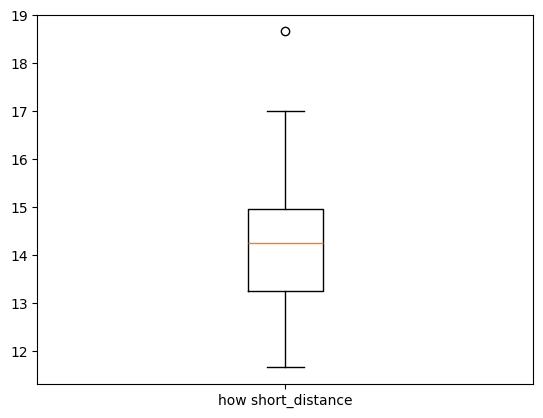

In [48]:
plt.boxplot([df_distances["mean"]],labels=["how short_distance"])

In [49]:
df_steps["mean"]
    
mean_steps_for_20x20_grid=df_steps["mean"].mean()
print (f"Therefore, for area of 20x20, the steps needed to converge is around {mean_steps_for_20x20_grid}. The averages are computed by running the experiment {n} times")

Therefore, for area of 20x20, the steps needed to converge is around 116.91666666666667. The averages are computed by running the experiment 10 times


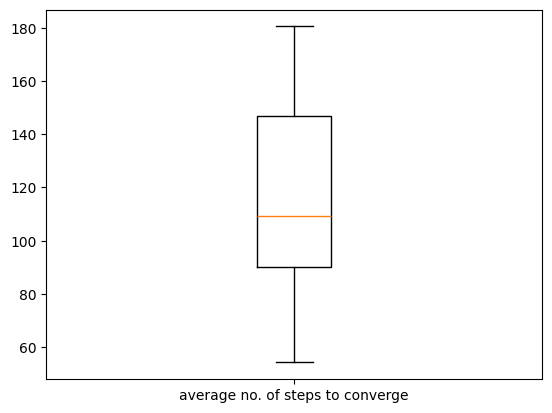

In [50]:
plt.boxplot(df_steps["mean"],labels=["average no. of steps to converge"])
plt.show()